In [1]:
from gensim.models import KeyedVectors

from utils import BigNum
import pandas as pd
import numpy as np
from pathlib import Path
import math
from matplotlib import pyplot as plt

from IPython import display

from sklearn.decomposition import PCA

In [2]:
IMAGES_ROOT = Path('images/mikolov/')
MODEL_PATH = '/mnt/datasets/datasets/nlp/WordVectors/GoogleNews-vectors-negative300.bin.gz'

IMAGES_ROOT.mkdir(exist_ok=True)

In [58]:
from itertools import count, islice, repeat, groupby
from utils import format_big_number

def count_exp(start=10, steps=2, exp=10, prefix='centroid-'):
    i_start = math.ceil(math.log10(start))
    for i in count(i_start):
        for j in range(0, exp, exp//steps):
            number = exp**i + (exp**i) * max(j-1,0)
            yield from repeat(BigNum(number, prefix=prefix), number)
            
def count_exp(start=1, steps=2, exp=10, prefix=''):
    last_number = 0
    i_start = math.ceil(math.log10(start))
    for i in count(i_start):
        for j in range(0, exp, exp//steps):
            number = exp**i + (exp**i) * max(j-1,0)
            if j + exp//steps < exp:
                next_j = j + exp//steps
                next_i = i
            else:
                next_j = 0
                next_i = i + 1
            next_number = exp**next_i + (exp**next_i) * max(next_j-1,0)
            if number == 1:
                yield f'{prefix}1'
            else:
                yield from repeat(f'{prefix}{format_big_number(number)}-{format_big_number(next_number)}', number)
            last_number = number

def plot_2d_proj(df_words, model, proj, cmap, label_prefix=''):
    fig, ax = plt.subplots(figsize=(20, 20), ncols=1)

    plt.suptitle("Centroids Space - By Frequency")

    centroids_by_cat = {
        cat: model.vectors[words.index].mean(axis=0)
        for cat, words in df_words.groupby('cluster', sort=False)
    }
    y_scale = proj2d.get_covariance().max() * 0.1
    for cat in centroids_by_cat:
        print(cat)
        emb_centroids_2d = proj.transform(np.expand_dims(centroids_by_cat[cat], 0))
        ax.plot(emb_centroids_2d[:,0], emb_centroids_2d[:,1], marker='o', markersize=15, label=f'{label_prefix}{cat}', color=cmap[cat])
        ax.text(emb_centroids_2d[0,0], emb_centroids_2d[0,1] + y_scale, str(cat))
    ax.legend()
    ax.grid()
    return fig

def plot_3d_proj(df_words, model, proj, cmap, label_prefix=''):
    fig, ax = plt.subplots(figsize=(20, 20), ncols=1, subplot_kw=dict(projection='3d'))

    plt.suptitle("Centroids Space - By Frequency")

    centroids_by_cat = {
        cat: model.vectors[words.index].mean(axis=0)
        for cat, words in df_words.groupby('cluster', sort=False)
    }

    for cat in centroids_by_cat:
        emb_centroids_3d = proj.transform(np.expand_dims(centroids_by_cat[cat], 0))
        
        ax.plot(emb_centroids_3d[:,0], emb_centroids_3d[:,1], emb_centroids_3d[:,1], marker='o', markersize=15, label=f'{label_prefix}{cat}', color=cmap[cat])
        ax.text(emb_centroids_3d[0,0], emb_centroids_3d[0,1], emb_centroids_3d[0,1], str(cat))
    ax.legend()
    ax.grid()
    return fig

In [19]:
model = KeyedVectors.load_word2vec_format(MODEL_PATH, binary=True)

In [20]:
proj2d = PCA(n_components=2).fit(model.vectors)
proj3d = PCA(n_components=3).fit(model.vectors)

0.002058365015678006

In [33]:
df_words = pd.concat({
    'name': pd.Series(model.index_to_key),
    'cluster': pd.Series(dict(zip(range(len(model.index_to_key)), count_exp(1, 2, prefix='centroid-'))))
}, axis=1)
df_words.cluster.value_counts()

centroid-5M-10M       1333334
centroid-1M-5M        1000000
centroid-500K-1M       500000
centroid-100K-500K     100000
centroid-50K-100K       50000
centroid-10K-50K        10000
centroid-5K-10K          5000
centroid-1K-5K           1000
centroid-500-1K           500
centroid-100-500          100
centroid-50-100            50
centroid-10-50             10
centroid-5-10               5
centroid-1                  1
Name: cluster, dtype: int64

1
5-10
10-50
50-100
100-500
500-1K
1K-5K
5K-10K
10K-50K
50K-100K
100K-500K
500K-1M
1M-5M
5M-10M


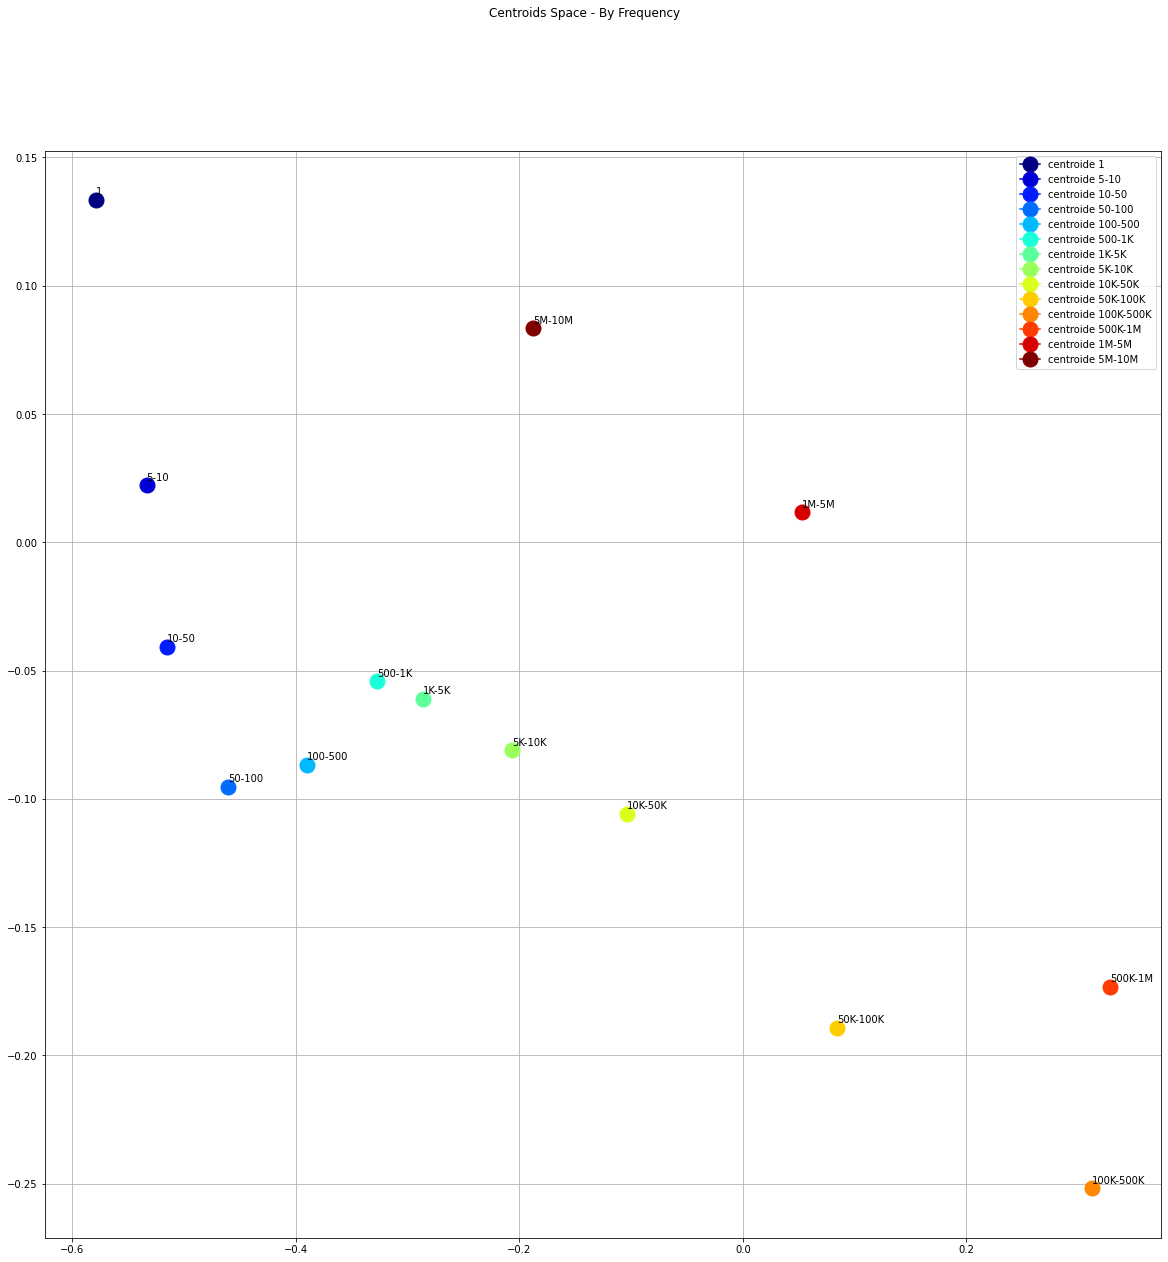

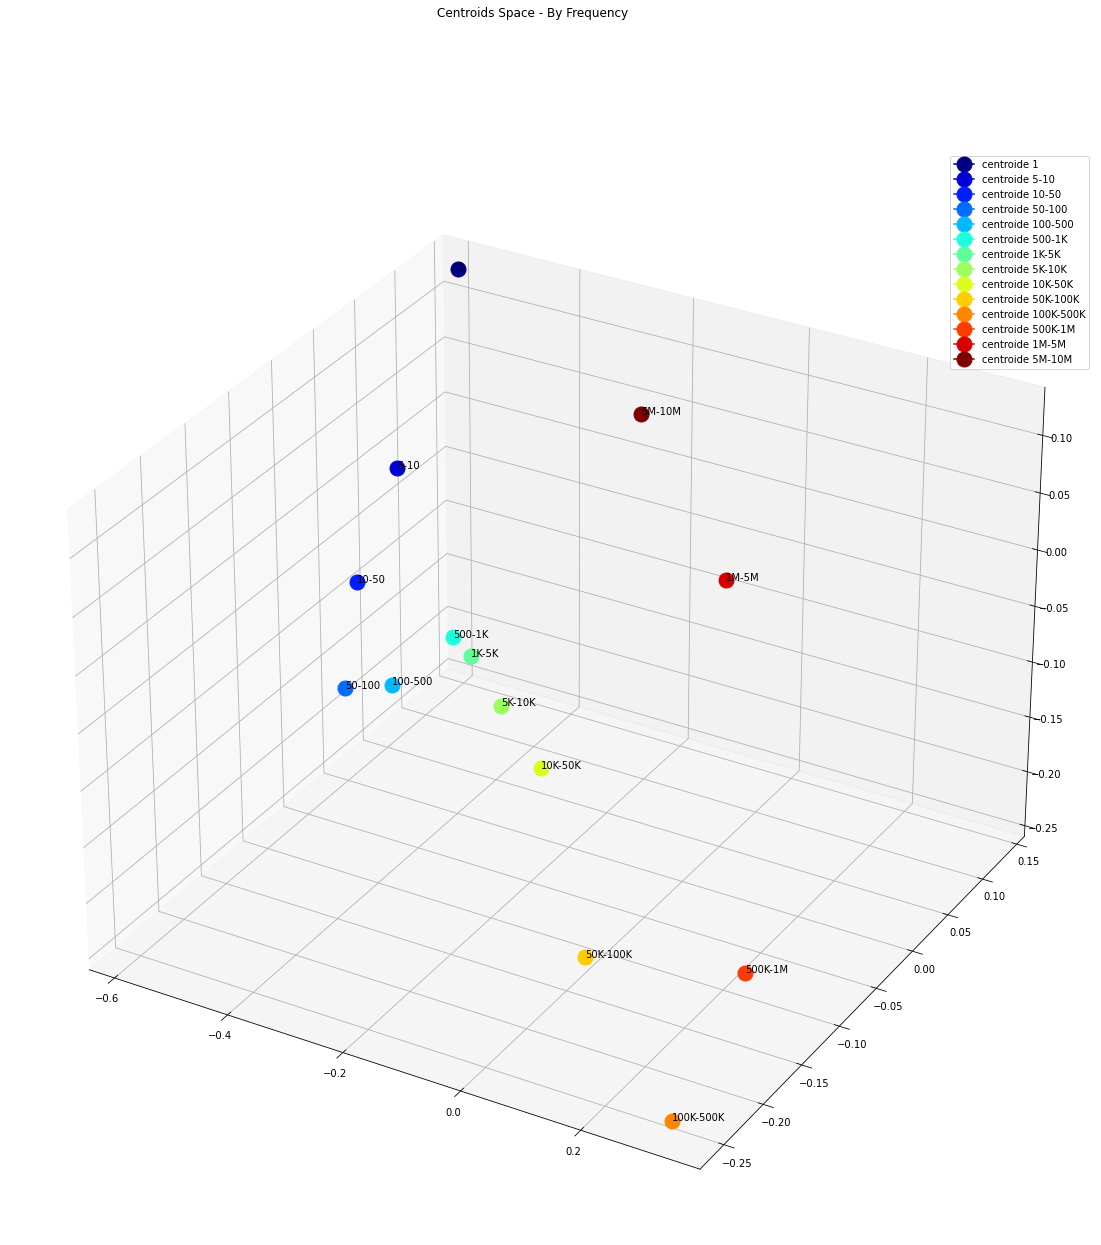

In [59]:
df_words = pd.concat({
    'name': pd.Series(model.index_to_key),
    'cluster': pd.Series(dict(zip(range(len(model.index_to_key)), count_exp(1, 2, prefix=''))))
}, axis=1)
#display.display(df_words)

CMAP = plt.get_cmap('jet')
CMAP_by_cat = {
    c: CMAP(i/(len(df_words.cluster.unique())-1))
    for i, c in enumerate(df_words.cluster.unique())
}

fig = plot_2d_proj(df_words, model, proj2d, CMAP_by_cat, label_prefix='centroide '); fig.savefig(IMAGES_ROOT/'mikolov_freq-2d.png'); plt.show(); plt.close()
fig = plot_3d_proj(df_words, model, proj3d, CMAP_by_cat, label_prefix='centroide '); fig.savefig(IMAGES_ROOT/'mikolov_freq-3d.png'); plt.show(); plt.close()